In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
orders = pd.read_parquet(r"C:\Users\benja\Desktop\dabi2 Projekt\orders.parquet")
tips = pd.read_csv(r"C:\Users\benja\Desktop\dabi2 Projekt\tips_public.csv")
order_products = pd.read_csv(r"C:\Users\benja\Desktop\dabi2 Projekt\order_products_denormalized.csv")

In [3]:
order_products

,order_id,product_id,add_to_cart_order,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,Bulgarian Yogurt,120,16,dairy eggs,yogurt
1,1,11109,2,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses
2,1,10246,3,Organic Celery Hearts,83,4,produce,fresh vegetables
3,1,49683,4,Cucumber Kirby,83,4,produce,fresh vegetables
4,1,43633,5,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood
...,...,...,...,...,...,...,...,...
14857348,3421083,39678,6,Free & Clear Natural Dishwasher Detergent,74,17,household,dish detergents
14857349,3421083,11352,7,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,crackers
14857350,3421083,4600,8,All Natural French Toast Sticks,52,1,frozen,frozen breakfast
14857351,3421083,24852,9,Banana,24,4,produce,fresh fruits


In [4]:
orders_tips = pd.merge(orders, tips, on="order_id", how="inner")
orders_tips["tip_binary"] = orders_tips["tip"].astype(int) #Neue Spalte mit Binärzahlen ob getipt oder nicht
orders_tips

,order_id,user_id,order_date,Unnamed: 0,tip,tip_binary
0,1374495,3,2024-03-31 14:05:18,26,True,1
1,444309,3,2024-04-09 19:45:51,27,True,1
2,3002854,3,2024-04-30 16:25:20,28,True,1
3,2037211,3,2024-05-20 18:31:28,29,True,1
4,2710558,3,2024-06-01 17:52:27,30,True,1
...,...,...,...,...,...,...
1401595,3292671,206208,2025-01-27 11:34:46,3421063,False,0
1401596,3059777,206208,2025-02-09 10:08:18,3421064,False,0
1401597,2239861,206208,2025-02-18 04:40:09,3421065,True,1
1401598,1285346,206208,2025-02-23 11:33:43,3421066,True,1


#a.) AR1

In [5]:
df = orders_tips[["user_id", "order_id", "order_date", "tip_binary"]].copy()
df = df.sort_values(by=["user_id", "order_date"])

df["tip_prev"] = df.groupby("user_id")["tip_binary"].shift(1) #Lag von 1

df_ar1 = df.dropna(subset=["tip_prev"]).copy()#Entfernung von NAN-Weil erste Bestellung kein vor tip werte hat 

x = df_ar1[["tip_prev"]] #Trainingsdaten
y = df_ar1["tip_binary"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42 #Trainings und Testdaten aufteilung
)

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy_1 = accuracy_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy_1)
print("F1-Score:", f1_1)

Accuracy: 0.731171196727308
F1-Score: 0.7465540599982405


In [6]:
#b.) AR2

In [7]:
orders_tips

,order_id,user_id,order_date,Unnamed: 0,tip,tip_binary
0,1374495,3,2024-03-31 14:05:18,26,True,1
1,444309,3,2024-04-09 19:45:51,27,True,1
2,3002854,3,2024-04-30 16:25:20,28,True,1
3,2037211,3,2024-05-20 18:31:28,29,True,1
4,2710558,3,2024-06-01 17:52:27,30,True,1
...,...,...,...,...,...,...
1401595,3292671,206208,2025-01-27 11:34:46,3421063,False,0
1401596,3059777,206208,2025-02-09 10:08:18,3421064,False,0
1401597,2239861,206208,2025-02-18 04:40:09,3421065,True,1
1401598,1285346,206208,2025-02-23 11:33:43,3421066,True,1


In [10]:
df = orders_tips[["user_id", "order_id", "order_date", "tip_binary"]].copy()
df = df.sort_values(by=["user_id", "order_date"])

df["tip_prev_1"] = df.groupby("user_id")["tip_binary"].shift(1) #Lag 1 erzeugen
df["tip_prev_2"] = df.groupby("user_id")["tip_binary"].shift(2) #Lag 2 erzeugen

df_ar2 = df.dropna(subset=["tip_prev_1", "tip_prev_2"]).copy()

x = df_ar2[["tip_prev_1", "tip_prev_2"]]
y = df_ar2["tip_binary"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42 #Trainings und Testdaten aufteilung
)

model_ar2 = LogisticRegression()
model_ar2.fit(x_train, y_train)

y_pred = model_ar2.predict(x_test)

accuracy_2 = accuracy_score(y_test, y_pred)
f1_2 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy_2)
print("F1-Score:", f1_2)

Accuracy: 0.7331003334533557
F1-Score: 0.7495731046765695


In [ ]:
#Vergleich zwischen AR1 und AR2
scores = pd.DataFrame({
    "Modell": ["AR(1)", "AR(2)"],
    "Accuracy": [accuracy_1, accuracy_2],
    "F1-Score": [f1_1, f1_2]
})
scores

,Modell,Accuracy,F1-Score
0,AR(1),0.731171,0.746554
1,AR(2),0.733100,0.749573


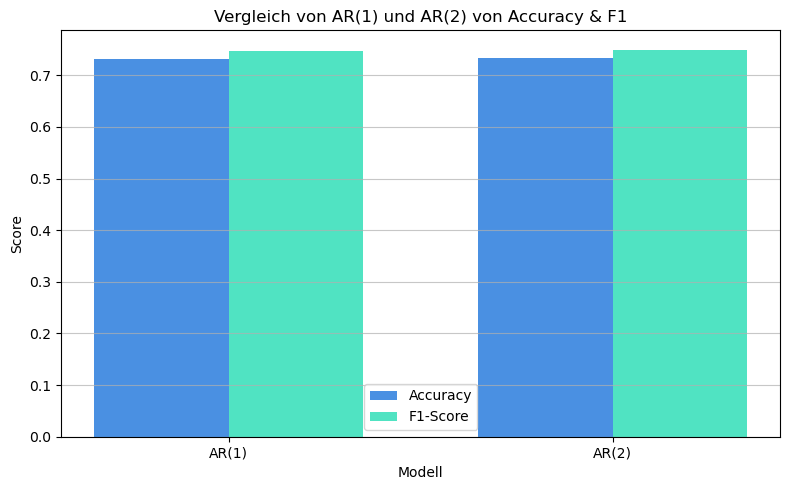

In [ ]:
modelle = ["AR(1)", "AR(2)"]
accuracies = [accuracy_1, accuracy_2]
f1_scores = [f1_1, f1_2]

x = range(len(modelle))

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35

ax.bar([i - bar_width/2 for i in x], accuracies, width=bar_width, label="Accuracy", color="#4a90e2")
ax.bar([i + bar_width/2 for i in x], f1_scores, width=bar_width, label="F1-Score", color="#50e3c2")

ax.set_xlabel("Modell")
ax.set_ylabel("Score")
ax.set_title("Vergleich von AR(1) und AR(2) von Accuracy & F1")
ax.set_xticks(x)
ax.set_xticklabels(modelle)
ax.legend()
ax.grid(axis="y", linestyle="solid", alpha=0.7)

plt.tight_layout()
plt.show()

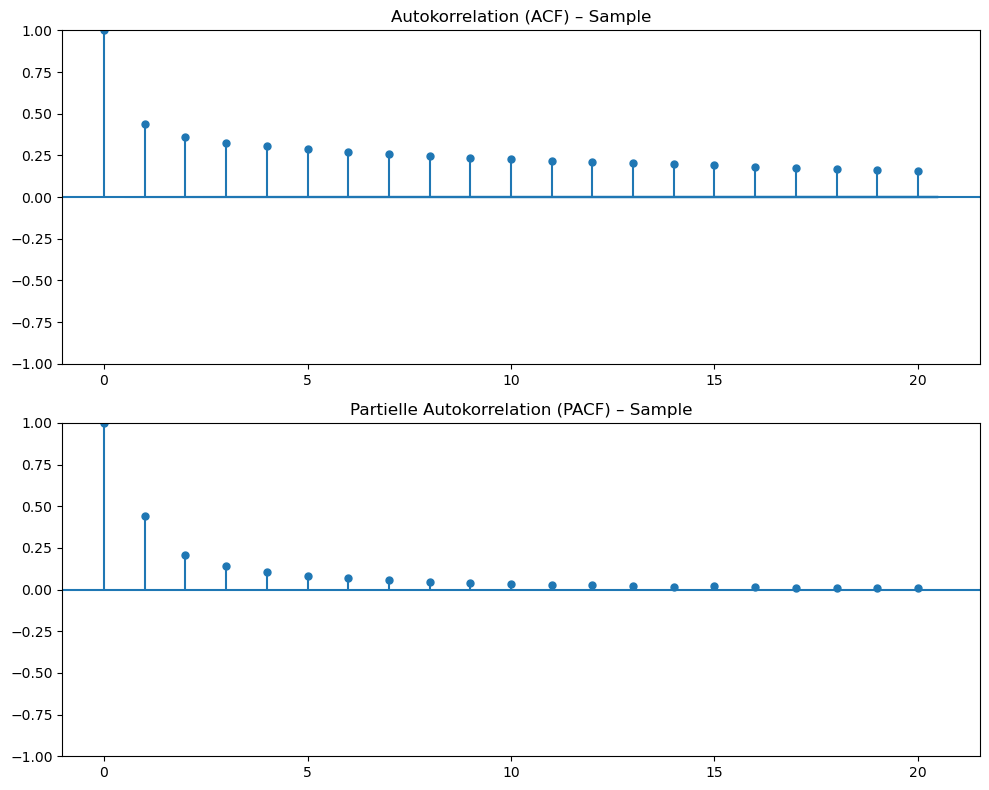

In [ ]:
series = orders_tips.sort_values(["user_id", "order_date"])["tip"].astype(int)

sample_size = 100000
series_sample = series.head(sample_size).reset_index(drop=True)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(series_sample, ax=ax[0], lags=15)
plot_pacf(series_sample, ax=ax[1], lags=15, method='ywm')
ax[0].set_title("Autokorrelation (ACF) – Sample")
ax[1].set_title("Partielle Autokorrelation (PACF) – Sample")
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

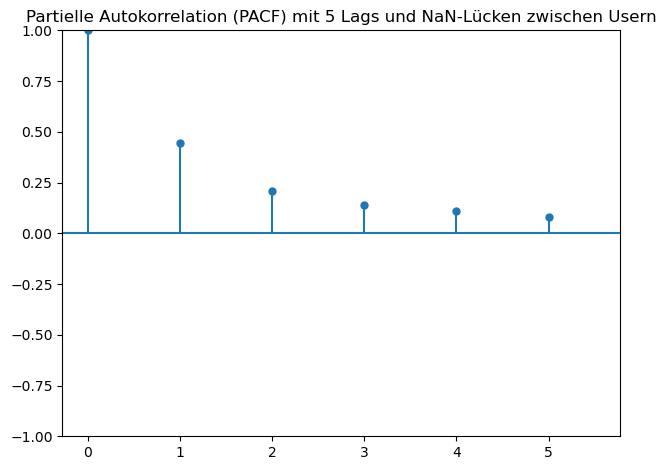

In [ ]:
n_lags = 5 

df = orders_tips[["user_id", "order_date", "tip"]].copy()
df = df.sort_values(["user_id", "order_date"])
df["tip_binary"] = df["tip"].astype(int)

all_series = []

for _, group in df.groupby("user_id"):
    series = group["tip_binary"].reset_index(drop=True)
    all_series.append(series)
    
    all_series.append(pd.Series([None] * n_lags))

combined_series = pd.concat(all_series, ignore_index=True)

plt.figure(figsize=(10, 5))
plot_pacf(combined_series.dropna(), lags=n_lags, method="ywm")
plt.title(f"Partielle Autokorrelation (PACF) mit {n_lags} Lags und NaN-Lücken zwischen Usern")
plt.tight_layout()
plt.show()

In [ ]:
#AR2 ist hier am besten

<Figure size 1000x500 with 0 Axes>

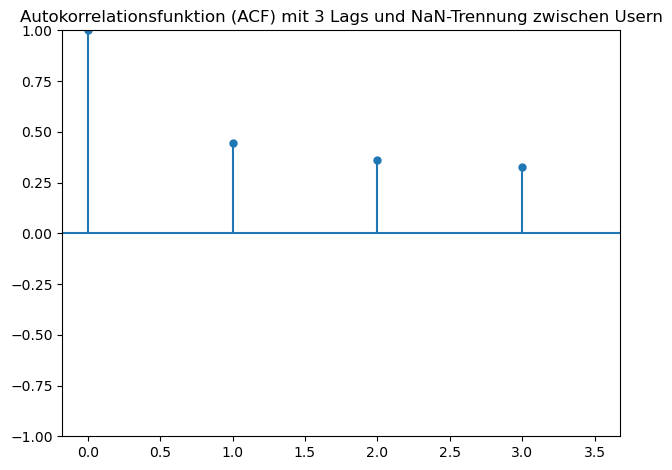

In [ ]:
n_lags = 3

df = orders_tips[["user_id", "order_date", "tip"]].copy()
df = df.sort_values(["user_id", "order_date"])
df["tip_binary"] = df["tip"].astype(int)

all_series = []

for _, group in df.groupby("user_id"):
    series = group["tip_binary"].reset_index(drop=True)
    all_series.append(series)
    
    all_series.append(pd.Series([None] * n_lags))

combined_series = pd.concat(all_series, ignore_index=True)

plt.figure(figsize=(10, 5))
plot_acf(combined_series.dropna(), lags=n_lags)
plt.title(f"Autokorrelationsfunktion (ACF) mit {n_lags} Lags und NaN-Trennung zwischen Usern")
plt.tight_layout()
plt.show()
#3 Lags verwendet da es sonst lange dauert

In [ ]:
#AR2 auch am besten

In [11]:
orders_tips['hour'] = orders_tips['order_date'].dt.hour


In [12]:
orders_tips.head(20)

,order_id,user_id,order_date,Unnamed: 0,tip,tip_binary,hour
0,1374495,3,2024-03-31 14:05:18,26,True,1,14
1,444309,3,2024-04-09 19:45:51,27,True,1,19
2,3002854,3,2024-04-30 16:25:20,28,True,1,16
3,2037211,3,2024-05-20 18:31:28,29,True,1,18
4,2710558,3,2024-06-01 17:52:27,30,True,1,17
5,1972919,3,2024-06-08 16:55:12,31,True,1,16
6,1839752,3,2024-06-15 15:04:06,32,False,0,15
7,3225766,3,2024-06-22 17:49:38,33,True,1,17
8,3160850,3,2024-06-29 16:49:34,34,False,0,16
9,676467,3,2024-07-16 16:27:44,35,True,1,16


In [13]:
# Group by hour and calculate the mean of tip_binary
tip_prob_by_hour = orders_tips.groupby('hour')['tip_binary'].mean() * 100

# Optionally, convert to DataFrame and rename column
tip_prob_by_hour = tip_prob_by_hour.reset_index().rename(columns={'tip_binary': 'tip_probability_Hour'})

tip_prob_by_hour = tip_prob_by_hour.sort_values(by='tip_probability_Hour', ascending=False)

tip_prob_by_hour

,hour,tip_probability_Hour
21,21,65.879632
22,22,65.607198
20,20,64.485398
23,23,63.874215
0,0,63.337393
19,19,63.046980
1,1,61.975985
2,2,61.899932
4,4,60.642040
3,3,58.461538


In [14]:
tip_chance_overall = orders_tips['tip_binary'].mean() * 100

tip_chance_overall


52.762985159817354

In [15]:
orders_tips['weekday_num'] = orders_tips['order_date'].dt.weekday
weekday_map = {
    0: 'Montag', 1: 'Dienstag', 2: 'Mittwoch', 3: 'Donnerstag',
    4: 'Freitag', 5: 'Samstag', 6: 'Sonntag'
}
orders_tips['weekday'] = orders_tips['order_date'].dt.weekday.map(weekday_map)


In [16]:
# Gruppieren nach Wochentag und Tipp-Wahrscheinlichkeit berechnen
tip_prob_by_weekday = orders_tips.groupby('weekday')['tip_binary'].mean() * 100

# In DataFrame umwandeln und Spalte umbenennen
tip_prob_by_weekday = tip_prob_by_weekday.reset_index().rename(columns={'tip_binary': 'tip_probability_Weekday'})

# Absteigend sortieren (höchste Tipp-Wahrscheinlichkeit zuerst)
tip_prob_by_weekday = tip_prob_by_weekday.sort_values(by='tip_probability_Weekday', ascending=False)

tip_prob_by_weekday


,weekday,tip_probability_Weekday
6,Sonntag,63.401347
5,Samstag,63.394375
1,Donnerstag,47.870183
2,Freitag,47.620771
3,Mittwoch,47.333820
4,Montag,47.253960
0,Dienstag,46.710015


In [17]:
orders_tips

,order_id,user_id,order_date,Unnamed: 0,tip,tip_binary,hour,weekday_num,weekday
0,1374495,3,2024-03-31 14:05:18,26,True,1,14,6,Sonntag
1,444309,3,2024-04-09 19:45:51,27,True,1,19,1,Dienstag
2,3002854,3,2024-04-30 16:25:20,28,True,1,16,1,Dienstag
3,2037211,3,2024-05-20 18:31:28,29,True,1,18,0,Montag
4,2710558,3,2024-06-01 17:52:27,30,True,1,17,5,Samstag
...,...,...,...,...,...,...,...,...,...
1401595,3292671,206208,2025-01-27 11:34:46,3421063,False,0,11,0,Montag
1401596,3059777,206208,2025-02-09 10:08:18,3421064,False,0,10,6,Sonntag
1401597,2239861,206208,2025-02-18 04:40:09,3421065,True,1,4,1,Dienstag
1401598,1285346,206208,2025-02-23 11:33:43,3421066,True,1,11,6,Sonntag


In [18]:
order_products

,order_id,product_id,add_to_cart_order,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,Bulgarian Yogurt,120,16,dairy eggs,yogurt
1,1,11109,2,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses
2,1,10246,3,Organic Celery Hearts,83,4,produce,fresh vegetables
3,1,49683,4,Cucumber Kirby,83,4,produce,fresh vegetables
4,1,43633,5,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood
...,...,...,...,...,...,...,...,...
14857348,3421083,39678,6,Free & Clear Natural Dishwasher Detergent,74,17,household,dish detergents
14857349,3421083,11352,7,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,crackers
14857350,3421083,4600,8,All Natural French Toast Sticks,52,1,frozen,frozen breakfast
14857351,3421083,24852,9,Banana,24,4,produce,fresh fruits


In [19]:
order_products['department'].unique()

array(['dairy eggs', 'produce', 'canned goods', 'snacks', 'pantry',
       'frozen', 'beverages', 'meat seafood', 'deli', 'household',
       'bakery', 'personal care', 'breakfast', 'babies',
       'dry goods pasta', 'other', 'international', 'missing', 'bulk',
       'alcohol', 'pets'], dtype=object)

In [20]:

alcohol_products = order_products['department'].str.contains('alcohol', case=False, na=False)




In [21]:
# Beispiel: falls du orders-Tabelle mit tip_binary hast
order_products_tip = order_products.merge(orders_tips[['order_id', 'tip_binary']], on='order_id', how='left')


In [22]:
# Gruppieren nach Department
tip_rate_by_department = (
    order_products_tip.groupby('department')['tip_binary']
    .agg(['count', 'sum'])  # count = total orders, sum = orders with tip
    .rename(columns={'count': 'total_orders', 'sum': 'tipped_orders'})
)

# Tippquote in Prozent berechnen
tip_rate_by_department['tip_rate_percent'] = (
    tip_rate_by_department['tipped_orders'] / tip_rate_by_department['total_orders'] * 100
)

# Optional: nach Tippquote sortieren
tip_rate_by_department = tip_rate_by_department.sort_values(by='tip_rate_percent', ascending=False)

tip_rate_by_department.reset_index(inplace=True)

tip_rate_by_department


,department,total_orders,tipped_orders,tip_rate_percent
0,alcohol,63122,55325.0,87.647730
1,bulk,17859,11267.0,63.088639
2,dairy eggs,2476064,1455162.0,58.769159
3,babies,211724,121500.0,57.386031
4,breakfast,322380,184868.0,57.344748
5,produce,4287740,2402239.0,56.025762
6,meat seafood,297396,161494.0,54.302681
7,personal care,184316,97232.0,52.752881
8,other,16453,8620.0,52.391661
9,household,297863,155476.0,52.197151


In [23]:
# Merge tip_binary auf order_products, falls nötig
order_products_tip = order_products.merge(orders_tips[['order_id', 'tip_binary']], on='order_id', how='left')


In [24]:
# Schritt 1: Produkt-Verkaufsanzahl berechnen (nicht unique pro Bestellung)
product_counts = order_products['product_id'].value_counts()

# Schritt 2: Schwellenwert für Top 10 % bestimmen
threshold = product_counts.quantile(0.90)

# Nur Produkte, die zu den Top 10 % nach Verkäufen gehören
top_10_percent_products = product_counts[product_counts >= threshold].index

# Schritt 3: Eindeutige Kombinationen Bestellung × Produkt
product_per_order = order_products_tip[['order_id', 'product_id', 'product_name', 'tip_binary']].drop_duplicates()

# Schritt 4: Auf Top-Produkte filtern
filtered = product_per_order[product_per_order['product_id'].isin(top_10_percent_products)]

# Schritt 5: Tippquote berechnen
tip_rate_by_top_products = (
    filtered.groupby(['product_id', 'product_name'])['tip_binary']
    .agg(['count', 'sum'])  # count = total_orders, sum = tipped_orders
    .rename(columns={'count': 'total_orders', 'sum': 'tipped_orders'})
)

tip_rate_by_top_products['tip_rate_percent'] = (
    tip_rate_by_top_products['tipped_orders'] / tip_rate_by_top_products['total_orders'] * 100
)

# Optional sortieren
tip_rate_by_top_products = tip_rate_by_top_products.sort_values(by='tip_rate_percent', ascending=False).reset_index()

# Ausgabe
tip_rate_by_top_products


,product_id,product_name,total_orders,tipped_orders,tip_rate_percent
0,47031,Kentucky Straight Bourbon Whiskey,482,441.0,91.493776
1,29509,80 Vodka Holiday Edition,777,706.0,90.862291
2,6878,Red Blend,593,538.0,90.725126
3,2120,Sauvignon Blanc,3472,3129.0,90.120968
4,36425,Chardonnay Wine,843,758.0,89.916963
...,...,...,...,...,...
4850,42360,Farmhouse Hearty White Bread,874,270.0,30.892449
4851,46823,The Ultimate Beefless Burger,461,140.0,30.368764
4852,18828,Organic Mint Tereré Yerba Mate Blend,464,135.0,29.094828
4853,49086,"Coconut Bliss Frozen Dessert, Dark Chocolate",583,160.0,27.444254


In [25]:
order_products

,order_id,product_id,add_to_cart_order,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,Bulgarian Yogurt,120,16,dairy eggs,yogurt
1,1,11109,2,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses
2,1,10246,3,Organic Celery Hearts,83,4,produce,fresh vegetables
3,1,49683,4,Cucumber Kirby,83,4,produce,fresh vegetables
4,1,43633,5,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood
...,...,...,...,...,...,...,...,...
14857348,3421083,39678,6,Free & Clear Natural Dishwasher Detergent,74,17,household,dish detergents
14857349,3421083,11352,7,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,crackers
14857350,3421083,4600,8,All Natural French Toast Sticks,52,1,frozen,frozen breakfast
14857351,3421083,24852,9,Banana,24,4,produce,fresh fruits


In [26]:
order_products_tip.sort_values(by=["order_id", "add_to_cart_order"], ascending=True).head(20)


,order_id,product_id,add_to_cart_order,product_name,aisle_id,department_id,department,aisle,tip_binary
0,1,49302,1,Bulgarian Yogurt,120,16,dairy eggs,yogurt,NaN
1,1,11109,2,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses,NaN
2,1,10246,3,Organic Celery Hearts,83,4,produce,fresh vegetables,NaN
3,1,49683,4,Cucumber Kirby,83,4,produce,fresh vegetables,NaN
4,1,43633,5,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood,NaN
5,1,13176,6,Bag of Organic Bananas,24,4,produce,fresh fruits,NaN
6,1,47209,7,Organic Hass Avocado,24,4,produce,fresh fruits,NaN
7,1,22035,8,Organic Whole String Cheese,21,16,dairy eggs,packaged cheese,NaN
430441,4,46842,1,Plain Pre-Sliced Bagels,93,3,bakery,breakfast bakery,1.0
430442,4,26434,2,Honey/Lemon Cough Drops,11,11,personal care,cold flu allergy,1.0


In [27]:
order_products_tip_percent = order_products_tip.merge(
    tip_rate_by_top_products[['product_id', 'tip_rate_percent']],
    on='product_id',
    how='left'  # Produkte außerhalb der Top 10% haben NaN
)

In [28]:
order_products_tip_percent['max_tip_rate_percent'] = (
    order_products_tip_percent.groupby('order_id')['tip_rate_percent'].transform('max')
)


In [35]:
order_products_tip_percent.sort_values('order_id', ascending=True).head(20)

,order_id,product_id,add_to_cart_order,product_name,aisle_id,department_id,department,aisle,tip_binary,tip_rate_percent
0,1,49302,1,Bulgarian Yogurt,120,16,dairy eggs,yogurt,NaN,NaN
1,1,11109,2,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses,NaN,58.424989
2,1,10246,3,Organic Celery Hearts,83,4,produce,fresh vegetables,NaN,51.830042
3,1,49683,4,Cucumber Kirby,83,4,produce,fresh vegetables,NaN,57.883581
4,1,43633,5,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood,NaN,NaN
5,1,13176,6,Bag of Organic Bananas,24,4,produce,fresh fruits,NaN,64.701544
6,1,47209,7,Organic Hass Avocado,24,4,produce,fresh fruits,NaN,55.013961
7,1,22035,8,Organic Whole String Cheese,21,16,dairy eggs,packaged cheese,NaN,61.266270
430452,4,32645,12,Sugarfree Energy Drink,64,7,beverages,energy sports drinks,1.0,NaN
430451,4,25146,11,Original Orange Juice,31,7,beverages,refrigerated,1.0,47.555429


In [30]:
order_products_tip_percent = order_products_tip.merge(
    tip_rate_by_top_products[['product_id', 'tip_rate_percent']],
    on='product_id',
    how='left'  # Produkte außerhalb der Top 10% haben NaN
)

In [31]:
order_products_tip_percent_1 = order_products_tip_percent.merge(
    orders_tips,
    on='order_id',
    how='left'  # Produkte außerhalb der Top 10% haben NaN
)

In [32]:
orders_tips

,order_id,user_id,order_date,Unnamed: 0,tip,tip_binary,hour,weekday_num,weekday
0,1374495,3,2024-03-31 14:05:18,26,True,1,14,6,Sonntag
1,444309,3,2024-04-09 19:45:51,27,True,1,19,1,Dienstag
2,3002854,3,2024-04-30 16:25:20,28,True,1,16,1,Dienstag
3,2037211,3,2024-05-20 18:31:28,29,True,1,18,0,Montag
4,2710558,3,2024-06-01 17:52:27,30,True,1,17,5,Samstag
...,...,...,...,...,...,...,...,...,...
1401595,3292671,206208,2025-01-27 11:34:46,3421063,False,0,11,0,Montag
1401596,3059777,206208,2025-02-09 10:08:18,3421064,False,0,10,6,Sonntag
1401597,2239861,206208,2025-02-18 04:40:09,3421065,True,1,4,1,Dienstag
1401598,1285346,206208,2025-02-23 11:33:43,3421066,True,1,11,6,Sonntag


In [37]:
order_products_tip_percent

,order_id,product_id,add_to_cart_order,product_name,aisle_id,department_id,department,aisle,tip_binary,tip_rate_percent
0,1,49302,1,Bulgarian Yogurt,120,16,dairy eggs,yogurt,NaN,NaN
1,1,11109,2,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,dairy eggs,other creams cheeses,NaN,58.424989
2,1,10246,3,Organic Celery Hearts,83,4,produce,fresh vegetables,NaN,51.830042
3,1,49683,4,Cucumber Kirby,83,4,produce,fresh vegetables,NaN,57.883581
4,1,43633,5,Lightly Smoked Sardines in Olive Oil,95,15,canned goods,canned meat seafood,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
14857348,3421083,39678,6,Free & Clear Natural Dishwasher Detergent,74,17,household,dish detergents,1.0,58.771930
14857349,3421083,11352,7,Organic Mini Sandwich Crackers Peanut Butter,78,19,snacks,crackers,1.0,56.360990
14857350,3421083,4600,8,All Natural French Toast Sticks,52,1,frozen,frozen breakfast,1.0,53.369272
14857351,3421083,24852,9,Banana,24,4,produce,fresh fruits,1.0,66.702996


In [36]:
order_products_tip_reduced = order_products_tip_percent[['order_id', 'max_tip_rate_percent']].drop_duplicates()

KeyError: "['max_tip_rate_percent'] not in index"

In [ ]:
merged_df = orders_tips.merge(
    order_products_tip_reduced,
    on='order_id',
    how='left'
)

In [ ]:
# Optional: nur gewünschte Spalten behalten
merged_df = merged_df[['order_id', 'order_date','weekday', 'tip_binary', 'max_tip_rate_percent']]
merged_df['hour'] = merged_df['order_date'].dt.hour
merged_df

,order_id,order_date,weekday,tip_binary,max_tip_rate_percent,hour
0,1374495,2024-03-31 14:05:18,Sonntag,1,61.869536,14
1,444309,2024-04-09 19:45:51,Dienstag,1,58.920450,19
2,3002854,2024-04-30 16:25:20,Dienstag,1,59.743714,16
3,2037211,2024-05-20 18:31:28,Montag,1,59.363874,18
4,2710558,2024-06-01 17:52:27,Samstag,1,61.266270,17
...,...,...,...,...,...,...
1401595,3292671,2025-01-27 11:34:46,Montag,0,64.701544,11
1401596,3059777,2025-02-09 10:08:18,Sonntag,0,62.711623,10
1401597,2239861,2025-02-18 04:40:09,Dienstag,1,64.701544,4
1401598,1285346,2025-02-23 11:33:43,Sonntag,1,64.701544,11


In [ ]:
# Merge Tipprate nach Stunde
merged_df = merged_df.merge(
    tip_prob_by_hour,
    on='hour',
    how='left'
)

In [ ]:
merged_df

,order_id,order_date,weekday,tip_binary,max_tip_rate_percent,hour,tip_rate_hour,tip_rate_weekday,tip_probability_Hour
0,1374495,2024-03-31 14:05:18,Sonntag,1,61.869536,14,50.299570,63.401347,50.299570
1,444309,2024-04-09 19:45:51,Dienstag,1,58.920450,19,63.046980,46.710015,63.046980
2,3002854,2024-04-30 16:25:20,Dienstag,1,59.743714,16,49.798165,46.710015,49.798165
3,2037211,2024-05-20 18:31:28,Montag,1,59.363874,18,49.045294,47.253960,49.045294
4,2710558,2024-06-01 17:52:27,Samstag,1,61.266270,17,49.166781,63.394375,49.166781
...,...,...,...,...,...,...,...,...,...
1401595,3292671,2025-01-27 11:34:46,Montag,0,64.701544,11,51.255096,47.253960,51.255096
1401596,3059777,2025-02-09 10:08:18,Sonntag,0,62.711623,10,52.547446,63.401347,52.547446
1401597,2239861,2025-02-18 04:40:09,Dienstag,1,64.701544,4,60.642040,46.710015,60.642040
1401598,1285346,2025-02-23 11:33:43,Sonntag,1,64.701544,11,51.255096,63.401347,51.255096


In [ ]:
# Merge Tipprate nach Wochentag
merged_df = merged_df.merge(
    tip_prob_by_weekday,
    on='weekday',
    how='left'
)

In [ ]:
merged_df

,order_id,order_date,weekday,tip_binary,max_tip_rate_percent,hour,tip_rate_hour,tip_rate_weekday,tip_probability_Hour,tip_probability_Weekday
0,1374495,2024-03-31 14:05:18,Sonntag,1,61.869536,14,50.299570,63.401347,50.299570,63.401347
1,444309,2024-04-09 19:45:51,Dienstag,1,58.920450,19,63.046980,46.710015,63.046980,46.710015
2,3002854,2024-04-30 16:25:20,Dienstag,1,59.743714,16,49.798165,46.710015,49.798165,46.710015
3,2037211,2024-05-20 18:31:28,Montag,1,59.363874,18,49.045294,47.253960,49.045294,47.253960
4,2710558,2024-06-01 17:52:27,Samstag,1,61.266270,17,49.166781,63.394375,49.166781,63.394375
...,...,...,...,...,...,...,...,...,...,...
1401595,3292671,2025-01-27 11:34:46,Montag,0,64.701544,11,51.255096,47.253960,51.255096,47.253960
1401596,3059777,2025-02-09 10:08:18,Sonntag,0,62.711623,10,52.547446,63.401347,52.547446,63.401347
1401597,2239861,2025-02-18 04:40:09,Dienstag,1,64.701544,4,60.642040,46.710015,60.642040,46.710015
1401598,1285346,2025-02-23 11:33:43,Sonntag,1,64.701544,11,51.255096,63.401347,51.255096,63.401347
